In [1]:
from glob import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from PIL import Image
import random
import shutil
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

# Utils

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
    return img


def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path, flush=True)
    return ckpt


def save_checkpoint(state, save_path):
    torch.save(state, save_path)


def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad


def init_weights(model, gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    model.apply(init_func)

In [3]:
set_seed(742)

# Dataset and Dataloader

In [4]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = dict()
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        return photo_img, monet_img

    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

In [5]:
img_ds = ImageDataset('../input/gan-getting-started/monet_jpg/', '../input/gan-getting-started/photo_jpg/')

In [6]:
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

In [7]:
photo_img, monet_img = next(iter(img_dl))

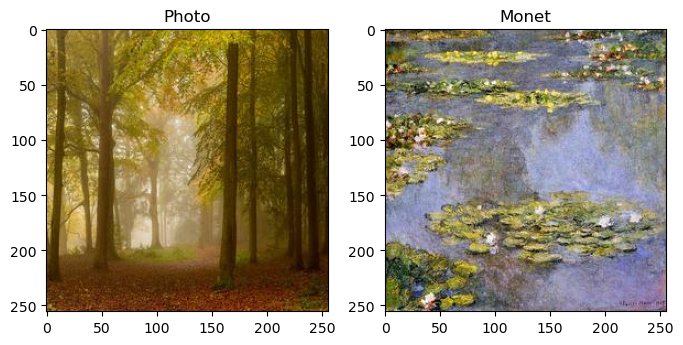

In [8]:
f = plt.figure(figsize=(8, 8))

f.add_subplot(1, 2, 1)
plt.title('Photo')
photo_img = unnorm(photo_img)
plt.imshow(photo_img[0].permute(1, 2, 0))

f.add_subplot(1, 2, 2)
plt.title('Monet')
monet_img = unnorm(monet_img)
plt.imshow(monet_img[0].permute(1, 2, 0))
plt.show()

# Layers and blocks

In [9]:
def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):
    if use_dropout:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.Dropout(dropout_ratio),
            nn.GELU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.GELU()
        )
    

def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)

    return nn.Sequential(conv, norm, actv)


class Resblock(nn.Module):
    def __init__(self, in_features, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

# Generator

In [13]:
class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=10):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(3))
        layers.append(Convlayer(in_ch, 64, 7, 1, False, True, False))
        layers.append(Convlayer(64, 128, 3, 2, False))
        layers.append(Convlayer(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            layers.append(Resblock(256))
        layers.append(Upsample(256, 128))
        layers.append(Upsample(128, 64))
        layers.append(nn.ReflectionPad2d(3))
        layers.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
        layers.append(nn.Tanh())
        self.gen = nn.Sequential(*layers)

    def forward(self, x):
        return self.gen(x)

# Discriminator

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=6):
        super().__init__()
        layers = list()
        layers.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_layers):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            if i == num_layers-1:
                layers.append(Convlayer(in_chs, out_chs, 4, 1))
            else:
                layers.append(Convlayer(in_chs, out_chs, 4, 2))
        layers.append(nn.Conv2d(2048, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*layers)

    def forward(self, x):
        return self.disc(x)

# Some additional classes

In [14]:
class ImageBuffer(object):
    def __init__(self, max_imgs=50):
        self.buff_size = max_imgs
        self.buff_used = 0
        self.img_buffer = list()

    def __call__(self, images):
        retval = list()
        for img in images:
            if self.buff_used < self.buff_size:
                self.img_buffer.append(img)
                retval.append(img)
                self.buff_used += 1
            else:
                if np.random.ranf() < 0.5:
                    idx = np.random.randint(0, self.buff_size)
                    retval.append(self.img_buffer[idx])
                    self.img_buffer[idx] = img
                else:
                    retval.append(img)
        return retval

In [15]:
class LRSched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

# CycleGAN class

In [22]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, alpha=10, beta=5, decay_epoch=-1):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(epochs/2)
        self.alpha = alpha
        self.beta = beta
        self.device = device
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.disc_m = Discriminator(in_ch)
        self.disc_p = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.optim_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                            lr = start_lr, betas=(0.5, 0.999))
        self.optim_disc = torch.optim.Adam(itertools.chain(self.disc_m.parameters(), self.disc_p.parameters()),
                                            lr=start_lr, betas=(0.5, 0.999))
        self.monet_buffer = ImageBuffer()
        self.photo_buffer = ImageBuffer()
        gen_lr = LRSched(self.decay_epoch, self.epochs)
        disc_lr = LRSched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.optim_gen, gen_lr.step)
        self.disc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.optim_disc, disc_lr.step)
        self.gen_losses = []
        self.disc_losses = []
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.disc_m)
        init_weights(self.disc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.disc_m = self.disc_m.to(self.device)
        self.disc_p = self.disc_p.to(self.device)
        
    def load_from_checkpoint(self, ckpt_path):
        ckpt = load_checkpoint(ckpt_path, map_location=self.device)
        self.epochs = ckpt['epoch']
        self.gen_mtp.load_state_dict(ckpt['gen_mtp'])
        self.gen_ptm.load_state_dict(ckpt['gen_ptm'])
        self.disc_m.load_state_dict(ckpt['disc_m'])
        self.disc_p.load_state_dict(ckpt['disc_p'])
        self.optim_gen.load_state_dict(ckpt['optim_gen'])
        self.optim_disc.load_state_dict(ckpt['optim_disc'])

    def save_current_state(self, epoch, ckpt_path):
        save_dict = {
            'epoch': epoch+1,
            'gen_mtp': self.gen_mtp.state_dict(),
            'gen_ptm': self.gen_ptm.state_dict(),
            'disc_m': self.disc_m.state_dict(),
            'disc_p': self.disc_p.state_dict(),
            'optim_gen': self.optim_gen.state_dict(),
            'optim_disc': self.optim_disc.state_dict()
        }
        save_checkpoint(save_dict, ckpt_path)

    def transfer_style(self, image_path, output_path):
        transform2Tensor = transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                           
        ])
        transform2Image = transforms.ToPILImage()

        image = Image.open(image_path, "r")
        img_tensor = transform2Tensor(image)
        
        with torch.no_grad():
            pred_monet = unnorm(self.gen_ptm(img_tensor.to(self.device)).cpu().detach())
            img = transform2Image(pred_monet).convert("RGB")
            img.save(output_path, "PNG")

    def train(self, photo_dl):
        for epoch in range(self.epochs):
            avg_gen_loss = 0.0
            avg_disc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for _, (real_photo, real_monet) in enumerate(t):
                real_photo, real_monet = real_photo.to(self.device), real_monet.to(self.device)
                
                # learn generator
                update_req_grad([self.disc_m, self.disc_p], False)
                self.optim_gen.zero_grad()

                # forward pass through generator
                fake_photo = self.gen_mtp(real_monet)
                fake_monet = self.gen_ptm(real_photo)

                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(real_monet)
                id_photo = self.gen_mtp(real_photo)

                monet_disc = self.disc_m(fake_monet)
                photo_disc = self.disc_p(fake_photo)

                # generator losses: identity, adversarial, cycle consistency
                idt_loss_monet = self.l1_loss(id_monet, real_monet) * self.beta
                idt_loss_photo = self.l1_loss(id_photo, real_photo) * self.beta

                cycle_loss_monet = self.l1_loss(cycl_monet, real_monet) * self.alpha
                cycle_loss_photo = self.l1_loss(cycl_photo, real_photo) * self.alpha

                adv_loss_monet = self.mse_loss(monet_disc, torch.ones(monet_disc.size()).to(self.device))
                adv_loss_photo = self.mse_loss(photo_disc, torch.ones(photo_disc.size()).to(self.device))

                # total generator loss
                total_gen_loss = cycle_loss_monet + cycle_loss_photo +\
                                adv_loss_monet + adv_loss_photo +\
                                idt_loss_monet + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                self.optim_gen.step()

                # learn discriminator
                update_req_grad([self.disc_m, self.disc_p], True)
                self.optim_disc.zero_grad()

                # forward pass through discriminator
                fake_monet = self.monet_buffer([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.photo_buffer([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                monet_disc_real = self.disc_m(real_monet)
                monet_disc_fake = self.disc_m(fake_monet)

                photo_disc_real = self.disc_p(real_photo)
                photo_disc_fake = self.disc_p(fake_photo)

                real = torch.ones(monet_disc_real.size()).to(self.device)
                fake = torch.zeros(monet_disc_fake.size()).to(self.device)

                # discriminator losses
                monet_disc_real_loss = self.mse_loss(monet_disc_real, real)
                monet_disc_fake_loss = self.mse_loss(monet_disc_fake, fake)
                photo_disc_real_loss = self.mse_loss(photo_disc_real, real)
                photo_disc_fake_loss = self.mse_loss(photo_disc_fake, fake)

                monet_disc_loss = (monet_disc_real_loss + monet_disc_fake_loss) / 2
                photo_disc_loss = (photo_disc_real_loss + photo_disc_fake_loss) / 2

                # total discriminator loss
                total_disc_loss = monet_disc_loss + photo_disc_loss
                avg_disc_loss += total_disc_loss.item()

                # backward pass
                total_disc_loss.backward()
                self.optim_disc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), disc_loss=total_disc_loss.item())
            
            if epoch % 10 == 0:
                self.save_current_state(epoch, 'current_weights'+str(epoch)+'.ckpt')

            self.gen_lr_sched.step()
            self.disc_lr_sched.step()

            avg_gen_loss /= photo_dl.__len__()
            avg_disc_loss /= photo_dl.__len__()
            self.gen_losses.append(avg_gen_loss)
            self.disc_losses.append(avg_disc_loss)
            
            print(f"Epoch: ({epoch+1}/{self.epochs})\n"
                  f"Generator Loss: {avg_gen_loss} | Discriminator Loss: {avg_disc_loss}\n")

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
gan = CycleGAN(3, 3, 120, device)

In [25]:
gan.train(img_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (1/120)
Generator Loss: 27.898501618703207 | Discriminator Loss: 25.723924589157104



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (2/120)
Generator Loss: 13.0811918703715 | Discriminator Loss: 1.9890630809466043



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (3/120)
Generator Loss: 11.876389357248941 | Discriminator Loss: 1.6586472823222478



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (4/120)
Generator Loss: 11.120756781895956 | Discriminator Loss: 1.4602547943592072



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (5/120)
Generator Loss: 10.681212134361267 | Discriminator Loss: 1.3069141512115796



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (6/120)
Generator Loss: 10.424672686258951 | Discriminator Loss: 1.292431647280852



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (7/120)
Generator Loss: 10.28852548758189 | Discriminator Loss: 1.4264463422695797



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (8/120)
Generator Loss: 9.932718151410421 | Discriminator Loss: 1.383693422873815



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (9/120)
Generator Loss: 9.459731200536092 | Discriminator Loss: 1.1582246685028077



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (10/120)
Generator Loss: 9.175068027178446 | Discriminator Loss: 1.1440652679403622



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (11/120)
Generator Loss: 9.377428736686706 | Discriminator Loss: 1.1062533205747604



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (12/120)
Generator Loss: 9.306222089131673 | Discriminator Loss: 1.2130772495269775



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (13/120)
Generator Loss: 8.98478777885437 | Discriminator Loss: 1.0448463700215023



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (14/120)
Generator Loss: 9.210860392252604 | Discriminator Loss: 1.1066349676251412



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (15/120)
Generator Loss: 9.25936075369517 | Discriminator Loss: 1.2046725350618361



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (16/120)
Generator Loss: 8.91128488222758 | Discriminator Loss: 1.0599251049757004



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (17/120)
Generator Loss: 8.712907835642497 | Discriminator Loss: 1.1131176373362541



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (18/120)
Generator Loss: 8.811346661249797 | Discriminator Loss: 1.0115588395794233



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (19/120)
Generator Loss: 8.968035969734192 | Discriminator Loss: 1.1028702668845654



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (20/120)
Generator Loss: 9.16717398484548 | Discriminator Loss: 1.048482472896576



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (21/120)
Generator Loss: 8.470191373825074 | Discriminator Loss: 0.8343340846896171



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (22/120)
Generator Loss: 8.683937617937724 | Discriminator Loss: 0.832304422458013



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (23/120)
Generator Loss: 8.323718876838685 | Discriminator Loss: 0.8818716366092364



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (24/120)
Generator Loss: 8.402330735524496 | Discriminator Loss: 0.9065519766509533



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (25/120)
Generator Loss: 8.039421931902568 | Discriminator Loss: 0.8394049539665381



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (26/120)
Generator Loss: 8.135458664894104 | Discriminator Loss: 0.7114745493233204



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (27/120)
Generator Loss: 8.134412055015565 | Discriminator Loss: 0.6387149295210839



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (28/120)
Generator Loss: 8.311421653429667 | Discriminator Loss: 0.9094434593121211



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (29/120)
Generator Loss: 8.195434659322103 | Discriminator Loss: 0.7213134996592998



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (30/120)
Generator Loss: 7.80175430615743 | Discriminator Loss: 0.5778748400509357



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (31/120)
Generator Loss: 7.9183663574854535 | Discriminator Loss: 0.5163562369346618



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (32/120)
Generator Loss: 8.18214745203654 | Discriminator Loss: 0.49351126357913017



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (33/120)
Generator Loss: 8.153597270647685 | Discriminator Loss: 0.6035634584973256



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (34/120)
Generator Loss: 7.9971602423985795 | Discriminator Loss: 0.566584383447965



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (35/120)
Generator Loss: 8.365900952021281 | Discriminator Loss: 0.5342744052410126



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (36/120)
Generator Loss: 8.392840863863627 | Discriminator Loss: 0.611318900535504



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (37/120)
Generator Loss: 8.352853506406149 | Discriminator Loss: 0.8708624415099621



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (38/120)
Generator Loss: 7.711592224438985 | Discriminator Loss: 0.4282870389521122



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (39/120)
Generator Loss: 7.83033774693807 | Discriminator Loss: 0.4523333336412907



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (40/120)
Generator Loss: 7.7011554940541584 | Discriminator Loss: 0.4399360899627209



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (41/120)
Generator Loss: 7.594796905517578 | Discriminator Loss: 0.42454840073982875



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (42/120)
Generator Loss: 7.906315169334412 | Discriminator Loss: 0.4818172299613555



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (43/120)
Generator Loss: 7.714559869766235 | Discriminator Loss: 0.37959429882466794



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (44/120)
Generator Loss: 7.755165214538574 | Discriminator Loss: 0.4486971432218949



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (45/120)
Generator Loss: 7.557288694381714 | Discriminator Loss: 0.4343951981017987



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (46/120)
Generator Loss: 7.565253213246663 | Discriminator Loss: 0.33393493441243965



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (47/120)
Generator Loss: 7.9928847551345825 | Discriminator Loss: 0.8392470371723175



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (48/120)
Generator Loss: 7.788161764144897 | Discriminator Loss: 0.7502039607862632



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (49/120)
Generator Loss: 7.178045473098755 | Discriminator Loss: 0.45634255612889923



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (50/120)
Generator Loss: 7.3248865572611495 | Discriminator Loss: 0.39617474084099136



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (51/120)
Generator Loss: 7.3822319046656295 | Discriminator Loss: 0.3758028414597114



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (52/120)
Generator Loss: 7.407707737286885 | Discriminator Loss: 0.38893239508072536



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (53/120)
Generator Loss: 7.437166120211283 | Discriminator Loss: 0.3546424396832784



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (54/120)
Generator Loss: 7.436660404205322 | Discriminator Loss: 0.3481610166778167



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (55/120)
Generator Loss: 7.460843834877014 | Discriminator Loss: 0.3011185838530461



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (56/120)
Generator Loss: 7.483797844250997 | Discriminator Loss: 0.30692282612125077



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (57/120)
Generator Loss: 7.770439594586691 | Discriminator Loss: 0.28815839283168315



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (58/120)
Generator Loss: 7.6706059408187866 | Discriminator Loss: 0.25079159198949735



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (59/120)
Generator Loss: 7.411072592735291 | Discriminator Loss: 0.281187603349487



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (60/120)
Generator Loss: 7.367524749437968 | Discriminator Loss: 0.25914792456974584



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (61/120)
Generator Loss: 7.349552838007609 | Discriminator Loss: 0.304109877422452



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (62/120)
Generator Loss: 7.243937859535217 | Discriminator Loss: 0.29021207908789315



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (63/120)
Generator Loss: 7.20796187877655 | Discriminator Loss: 0.24658774272849163



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (64/120)
Generator Loss: 7.154797086715698 | Discriminator Loss: 0.23257589362561704



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (65/120)
Generator Loss: 7.256636805534363 | Discriminator Loss: 0.2199165979772806



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (66/120)
Generator Loss: 7.126886806488037 | Discriminator Loss: 0.200447003642718



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (67/120)
Generator Loss: 7.104406077067058 | Discriminator Loss: 0.2123507583141327



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (68/120)
Generator Loss: 7.0598111867904665 | Discriminator Loss: 0.19353867458800475



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (69/120)
Generator Loss: 7.04435268719991 | Discriminator Loss: 0.17586169249688585



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (70/120)
Generator Loss: 6.975942419370015 | Discriminator Loss: 0.15619102254509926



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (71/120)
Generator Loss: 6.965211675961812 | Discriminator Loss: 0.17126786993195614



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (72/120)
Generator Loss: 6.97474650700887 | Discriminator Loss: 0.159392687783887



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (73/120)
Generator Loss: 6.86516126314799 | Discriminator Loss: 0.1604486094166835



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (74/120)
Generator Loss: 6.875044374465943 | Discriminator Loss: 0.14565847005074223



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (75/120)
Generator Loss: 6.883959153493246 | Discriminator Loss: 0.12252095836525162



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (76/120)
Generator Loss: 6.819495102564494 | Discriminator Loss: 0.10824096675341328



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (77/120)
Generator Loss: 6.746461901664734 | Discriminator Loss: 0.11099728716537356



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (78/120)
Generator Loss: 6.845391144752503 | Discriminator Loss: 0.1361515088006854



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (79/120)
Generator Loss: 6.7042104355494185 | Discriminator Loss: 0.08883371951058507



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (80/120)
Generator Loss: 6.594304997126262 | Discriminator Loss: 0.07734202720535298



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (81/120)
Generator Loss: 6.57736705938975 | Discriminator Loss: 0.07117823854709665



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (82/120)
Generator Loss: 6.6203128449122115 | Discriminator Loss: 0.0742604243196547



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (83/120)
Generator Loss: 6.614290471076965 | Discriminator Loss: 0.06391276795417071



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (84/120)
Generator Loss: 6.485913351376851 | Discriminator Loss: 0.06722461045098801



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (85/120)
Generator Loss: 6.531375862757365 | Discriminator Loss: 0.05968066928597788



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (86/120)
Generator Loss: 6.376680134137471 | Discriminator Loss: 0.06163717507074277



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (87/120)
Generator Loss: 6.356307598749797 | Discriminator Loss: 0.06668668616873523



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (88/120)
Generator Loss: 6.388509704271953 | Discriminator Loss: 0.09524925794452428



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (89/120)
Generator Loss: 6.3276798597971595 | Discriminator Loss: 0.04758931995059053



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (90/120)
Generator Loss: 6.190831937789917 | Discriminator Loss: 0.034163429924907784



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (91/120)
Generator Loss: 6.1993924379348755 | Discriminator Loss: 0.030014174037302534



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (92/120)
Generator Loss: 6.233628948529561 | Discriminator Loss: 0.02639136672175179



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (93/120)
Generator Loss: 6.089832978248596 | Discriminator Loss: 0.026322587452208



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (94/120)
Generator Loss: 6.026198550860087 | Discriminator Loss: 0.025547830099239947



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (95/120)
Generator Loss: 6.01154860496521 | Discriminator Loss: 0.02192780128524949



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (96/120)
Generator Loss: 6.007032872835795 | Discriminator Loss: 0.022699154851337274



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (97/120)
Generator Loss: 5.951364415486654 | Discriminator Loss: 0.020661178207956255



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (98/120)
Generator Loss: 5.968086727460226 | Discriminator Loss: 0.01934140906513979



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (99/120)
Generator Loss: 5.8756394879023235 | Discriminator Loss: 0.018281713440082968



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (100/120)
Generator Loss: 5.820369720458984 | Discriminator Loss: 0.014042360515644153



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (101/120)
Generator Loss: 5.737070307731629 | Discriminator Loss: 0.014684098325669765



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (102/120)
Generator Loss: 5.793044722874959 | Discriminator Loss: 0.011836082443284492



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (103/120)
Generator Loss: 5.7624671157201135 | Discriminator Loss: 0.009962143497541548



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (104/120)
Generator Loss: 5.7175331958134965 | Discriminator Loss: 0.009730903290522595



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (105/120)
Generator Loss: 5.617923453648885 | Discriminator Loss: 0.008844487882064034



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (106/120)
Generator Loss: 5.647544506390889 | Discriminator Loss: 0.007983436440893759



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (107/120)
Generator Loss: 5.637199029922486 | Discriminator Loss: 0.00682655767382433



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (108/120)
Generator Loss: 5.540971514383952 | Discriminator Loss: 0.00581442225452823



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (109/120)
Generator Loss: 5.526046355565389 | Discriminator Loss: 0.004942700155855467



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (110/120)
Generator Loss: 5.528859184583028 | Discriminator Loss: 0.004258570227151115



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (111/120)
Generator Loss: 5.442049151261648 | Discriminator Loss: 0.003145455434957209



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (112/120)
Generator Loss: 5.451595109303792 | Discriminator Loss: 0.002493178207272043



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (113/120)
Generator Loss: 5.459819804827372 | Discriminator Loss: 0.0021429860774272434



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (114/120)
Generator Loss: 5.347517690658569 | Discriminator Loss: 0.0017430872972666596



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (115/120)
Generator Loss: 5.474438568751017 | Discriminator Loss: 0.0013715887199699259



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (116/120)
Generator Loss: 5.343273056348165 | Discriminator Loss: 0.0010747055292207126



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (117/120)
Generator Loss: 5.376843717892965 | Discriminator Loss: 0.0008402200374014986



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (118/120)
Generator Loss: 5.329057782491049 | Discriminator Loss: 0.0006560363373137079



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (119/120)
Generator Loss: 5.268716172377268 | Discriminator Loss: 0.0005525339757635569



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (120/120)
Generator Loss: 5.306782805124919 | Discriminator Loss: 0.00042234975456570585



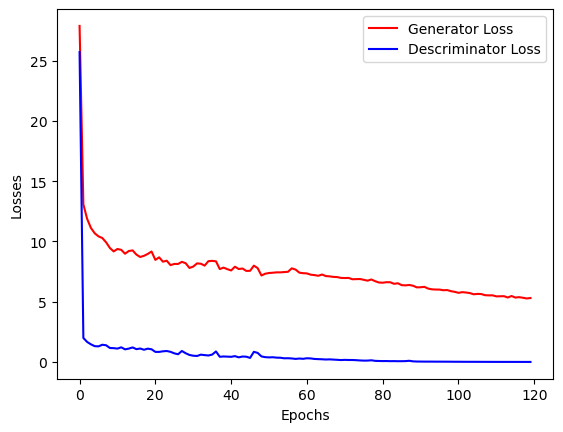

In [26]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_losses, 'r', label='Generator Loss')
plt.plot(gan.disc_losses, 'b', label='Descriminator Loss')
plt.legend()
plt.show()

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


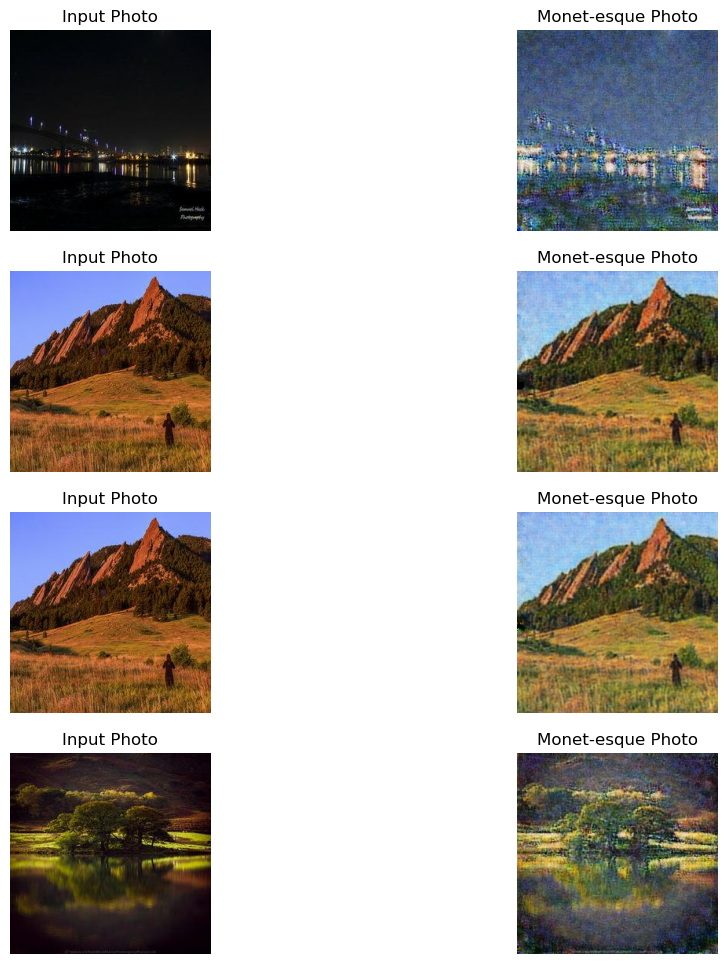

In [33]:
_, ax = plt.subplots(4, 2, figsize=(12,12))
for i in range(4):
    photo_img, _ = next(iter(img_dl))
    print(photo_img.shape)
    pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_monet = unnorm(pred_monet)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()